In [7]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import models


In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
model = models.mobilenet_v2(weights='MobileNet_V2_Weights.IMAGENET1K_V1')
model.to(DEVICE)
model.eval()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

## Model Exploration

In [4]:

# Define a function to calculate memory usage of a model
def compute_memory_usage(model, input_size=(3, 640, 640), batch_size=1):
    print(f"{'Layer':<30}{'Output Shape':<30}{'Param Count':<15}{'Weights (MB)':<15}{'Activations (MB)':<15}")
    print("-" * 100)
    
    total_params = 0
    total_weight_mem = 0
    global weight_mems
    weight_mems = []
    total_activation_mem = 0
    
    weight_means, weight_stds = [], []
    
    def hook(module, input, output):
        nonlocal total_params, total_weight_mem, total_activation_mem
        # global weight_mems
        
        # Calculate parameters
        # params = sum(p.numel() for p in module.parameters() if p.requires_grad)
        if isinstance(module, nn.Conv2d):
            p = next(iter(module.parameters()))
            weight_means.append(torch.mean(torch.abs(p)).item())
            weight_stds.append(torch.std(torch.abs(p)).item())
            
        # print((p.shape for p in module.parameters()))
        params = sum(p.numel() for p in module.parameters())
        size_of_param = [p.element_size() for p in module.parameters()]
        weight_mem_b = params * size_of_param[0] if len(size_of_param) > 0 else 0# Convert bytes to MB
        weight_mem_mb = weight_mem_b / (1024 ** 2) 
        total_params += params
        total_weight_mem += weight_mem_mb
        
        # Calculate activations
        if isinstance(output, (list, tuple)):
            activations = sum(o.numel() for o in output)
            size_of_activations = [o.element_size() for o in output]
            size_of_activations = size_of_activations[0]
        else:
            activations = output.numel()
            size_of_activations = output.element_size()
        activation_mem_b = activations * size_of_activations
        activation_mem_mb = activation_mem_b / (1024 ** 2)  # Convert bytes to MB
        total_activation_mem += activation_mem_mb
        
        weight_mems.append(weight_mem_b)
        print(f"{module.__class__.__name__:<30}{str(tuple(output.shape)):<30}{params:<15}{weight_mem_mb:<15.2f}{activation_mem_mb:<15.2f}")
    
    hooks = []
    for layer in model.modules():
        if len(list(layer.children())) == 0:  # Leaf node in the model
            hooks.append(layer.register_forward_hook(hook))
    
    # Create a random input tensor
    x = torch.randn(batch_size, *input_size).to(next(model.parameters()).device)
    model(x)  # Forward pass to trigger hooks
    
    for hook in hooks:
        hook.remove()
    
    print("-" * 100)
    print(f"Total Params: {total_params}")
    print(f"Total Weight Memory (MB): {total_weight_mem:.2f}")
    print(f"Total Activation Memory (MB): {total_activation_mem:.2f}")
    
    return weight_means, weight_stds

In [5]:
# Calculate memory usage
weight_means, weight_stds = compute_memory_usage(model, input_size=(3, 640, 640), batch_size=1)

Layer                         Output Shape                  Param Count    Weights (MB)   Activations (MB)
----------------------------------------------------------------------------------------------------
Conv2d                        (1, 32, 320, 320)             864            0.00           12.50          
BatchNorm2d                   (1, 32, 320, 320)             64             0.00           12.50          
ReLU6                         (1, 32, 320, 320)             0              0.00           12.50          
Conv2d                        (1, 32, 320, 320)             288            0.00           12.50          
BatchNorm2d                   (1, 32, 320, 320)             64             0.00           12.50          
ReLU6                         (1, 32, 320, 320)             0              0.00           12.50          
Conv2d                        (1, 16, 320, 320)             512            0.00           6.25           
BatchNorm2d                   (1, 16, 320, 320)   

<BarContainer object of 52 artists>

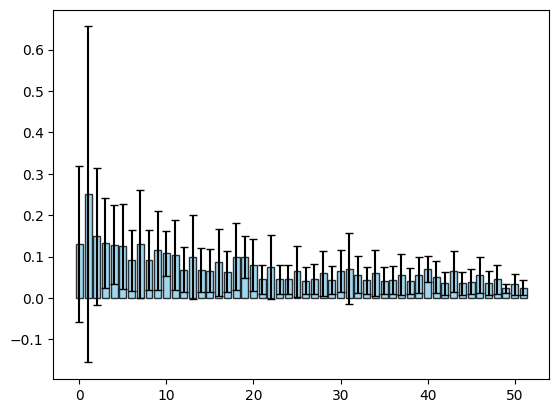

In [8]:
plt.bar(
        range(len(weight_means)),
        weight_means,
        yerr=weight_stds,
        capsize=3,
        color="skyblue",
        alpha=0.8,
        edgecolor="black",
        )

<BarContainer object of 52 artists>

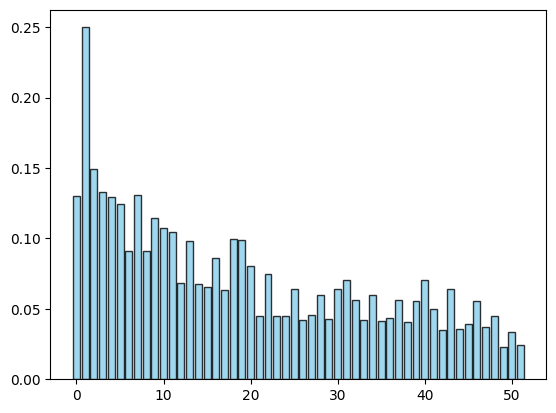

In [9]:
plt.bar(
        range(len(weight_means)),
        weight_means,
        capsize=3,
        color="skyblue",
        alpha=0.8,
        edgecolor="black",
        )

## Sensivity Analysis

In [2]:
import json
import matplotlib
# matplotlib.use("TkAgg")
import matplotlib.pyplot as plt
import numpy as np

In [3]:
with open('../runs/sensivity_analysis/sensivity_analysis.json', 'r') as f:
    data = json.load(f)
data

{'features.1.conv.0.1': {'top1': [0.71096, 0.5757, 0.03474, 0.0022, 0.00114],
  'top5': [0.89948, 0.813, 0.09788, 0.00736, 0.00558],
  'loss': [14.403162048663944,
   22.223612068686634,
   103.64576007798314,
   131.74684715643525,
   138.54842003434896]},
 'features.2.conv.1.1': {'top1': [0.57006, 0.02824, 0.00234, 0.00102, 0.00162],
  'top5': [0.80558, 0.09398, 0.0128, 0.00766, 0.00534],
  'loss': [22.71068325964734,
   109.75838568434119,
   157.76405614987016,
   167.2277132384479,
   113.75423611328006]},
 'features.3.conv.1.1': {'top1': [0.3765, 0.00972, 0.00236, 0.00208, 0.00204],
  'top5': [0.61622, 0.03884, 0.01028, 0.0079, 0.0078],
  'loss': [38.63741221651435,
   106.57205509021878,
   131.6942581795156,
   130.46310277096927,
   131.80611641332507]},
 'features.4.conv.1.1': {'top1': [0.38188, 0.0451, 0.00462, 0.00156, 0.00108],
  'top5': [0.61692, 0.11048, 0.01654, 0.00704, 0.00516],
  'loss': [38.688165878877044,
   90.7589758131653,
   114.93547889590263,
   107.02099776

In [4]:
top1 = 71.1
top5 = 89.956
loss = 14.403140256064944

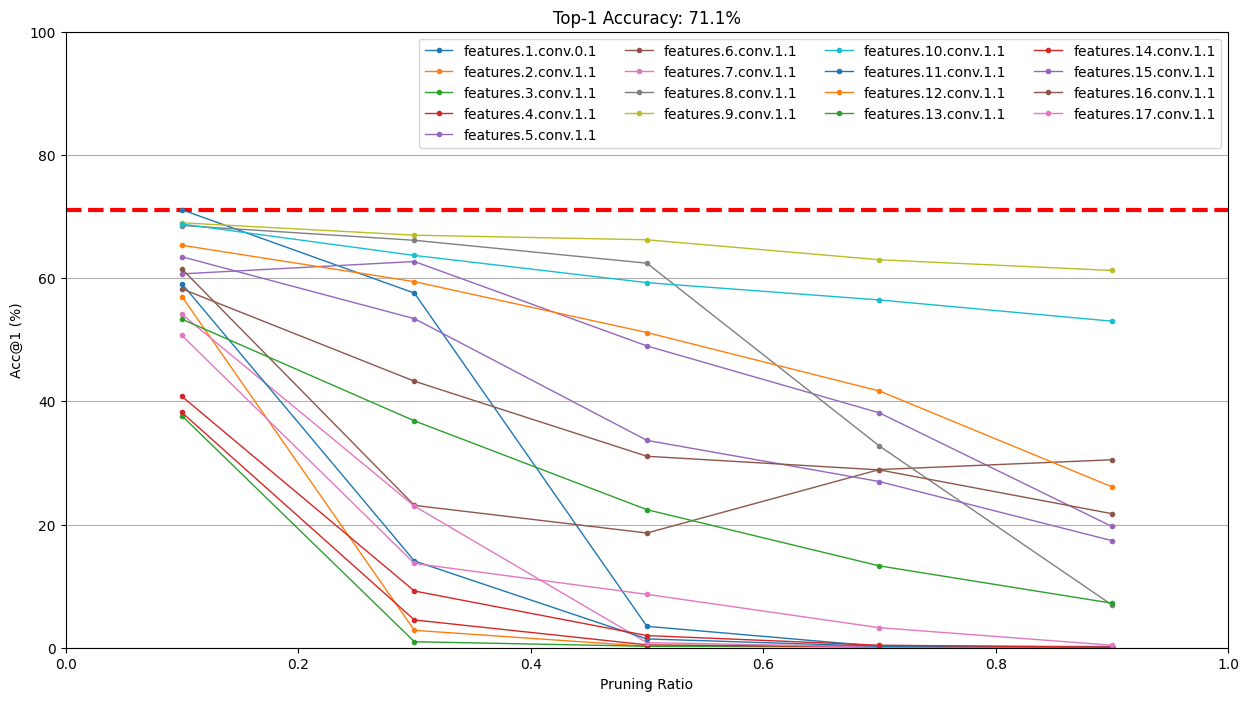

In [5]:
plt.figure(figsize=(15, 8))
plt.title(f"Top-1 Accuracy: {top1}%")
plt.plot(np.linspace(0, 1, 10), np.ones(10) * top1, color="red", linestyle="dashed", linewidth=3)
for bn_layer in data.keys():
    plt.plot([0.1, 0.3, 0.5, 0.7, 0.9], np.array(data[bn_layer]["top1"]) * 100, label=bn_layer, marker='o', markersize=3, linewidth=1)

plt.xlabel("Pruning Ratio")
plt.ylabel("Acc@1 (%)")
plt.xlim([0, 1])
plt.ylim([0, 100])
plt.grid(axis="y")
plt.legend(ncol=4)
plt.show()

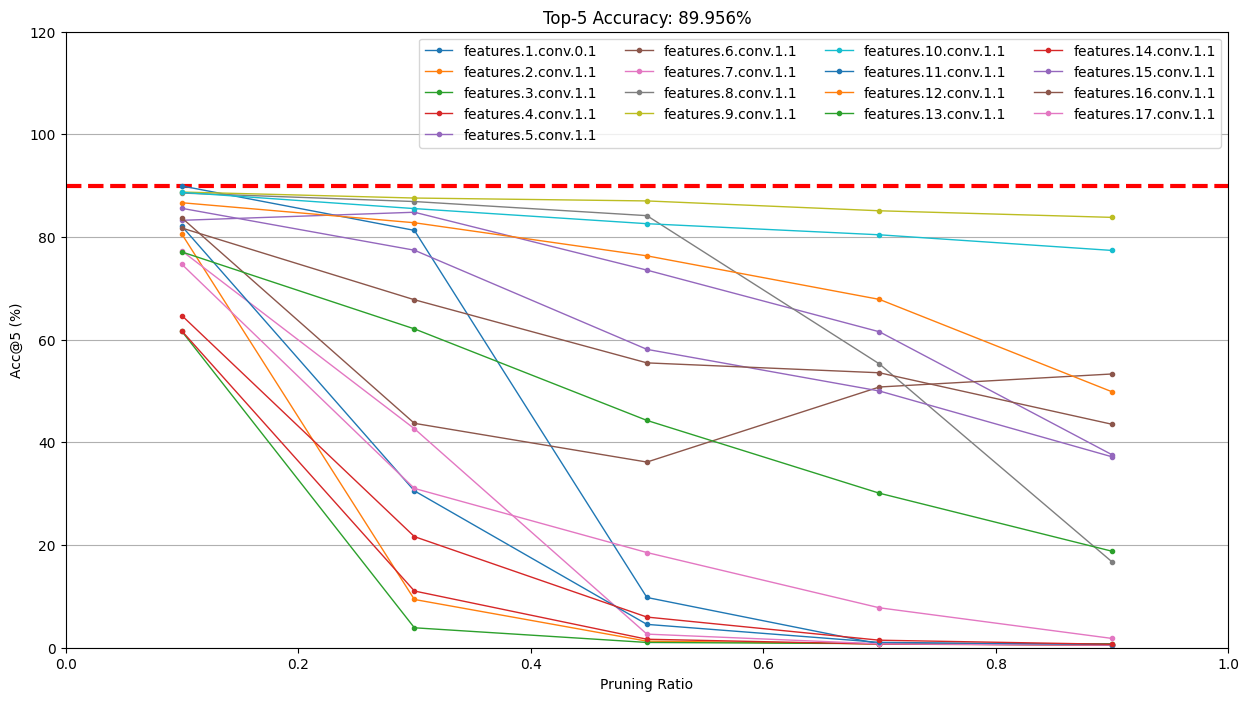

In [6]:
plt.figure(figsize=(15, 8))
plt.title(f"Top-5 Accuracy: {top5}%")
plt.plot(np.linspace(0, 1, 10), np.ones(10) * top5, color="red", linestyle="dashed", linewidth=3)
for bn_layer in data.keys():
    plt.plot([0.1, 0.3, 0.5, 0.7, 0.9], np.array(data[bn_layer]["top5"]) * 100, label=bn_layer, marker='o', markersize=3, linewidth=1)

plt.xlabel("Pruning Ratio")
plt.ylabel("Acc@5 (%)")
plt.xlim([0, 1])
plt.ylim([0, 120])
plt.grid(axis="y")
plt.legend(ncol=4)
plt.show()

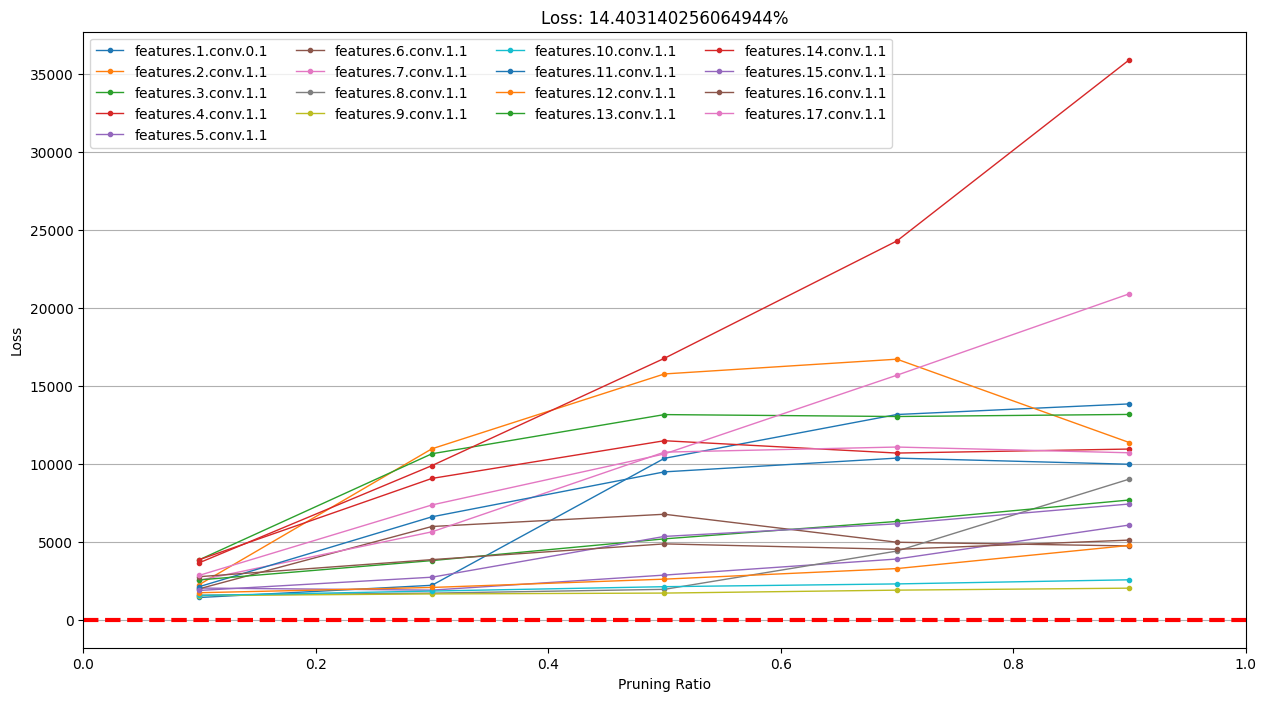

In [7]:
plt.figure(figsize=(15, 8))
plt.title(f"Loss: {loss}%")
plt.plot(np.linspace(0, 1, 10), np.ones(10) * loss, color="red", linestyle="dashed", linewidth=3)
for bn_layer in data.keys():
    plt.plot([0.1, 0.3, 0.5, 0.7, 0.9], np.array(data[bn_layer]["loss"]) * 100, label=bn_layer, marker='o', markersize=3, linewidth=1)

plt.xlabel("Pruning Ratio")
plt.ylabel("Loss")
plt.xlim([0, 1])
# plt.ylim([0, 120])
plt.grid(axis="y")
plt.legend(ncol=4)
plt.show()

## Interactive Plots

In [8]:
import matplotlib
matplotlib.use("TkAgg")
import matplotlib.pyplot as plt
import numpy as np

In [8]:
# Plot
fig, ax = plt.subplots(figsize=(15, 8))
plt.title(f"Top-1 Accuracy: {top1}%")

# Draw the dashed reference line
ax.plot(np.linspace(0, 1, 10), np.ones(10) * top1, color="red", linestyle="dashed", linewidth=3)

# Add the lines for each layer
lines = []
bn_layers = list(data.keys())
pruning_ratios = [0.1, 0.3, 0.5, 0.7, 0.9]

for bn_layer in bn_layers:
    line, = ax.plot(pruning_ratios, 
                    np.array(data[bn_layer]["top1"]) * 100, 
                    label=bn_layer, 
                    marker='o', 
                    markersize=5, 
                    linewidth=2, 
                    alpha=0.6)  # Default lower opacity
    lines.append(line)

# Add labels and legend
legend = ax.legend(ncol=4)
legend_texts = legend.get_texts()

# Highlight function
def on_pick(event):
    # Reset all lines and labels to default
    for line, text in zip(lines, legend_texts):
        line.set_linewidth(2)
        line.set_alpha(0.6)
        text.set_fontsize(10)
        text.set_color('black')
    
    # Highlight the selected line and label
    selected_line = event.artist
    selected_index = lines.index(selected_line)  # Get the index of the selected line
    selected_label = legend_texts[selected_index]
    
    # Modify line and label appearance
    selected_line.set_linewidth(4)
    selected_line.set_alpha(1.0)
    selected_label.set_fontsize(12)
    selected_label.set_color('red')
    
    # Redraw the figure
    fig.canvas.draw()

# Enable picking for each line
for line in lines:
    line.set_picker(True)

# Connect the pick event
fig.canvas.mpl_connect('pick_event', on_pick)

# Add grid and labels
plt.xlabel("Pruning Ratio")
plt.ylabel("Acc@1 (%)")
plt.xlim([0, 1])
plt.ylim([0, 120])
plt.grid(axis="y")
plt.show()


In [5]:
# Plot
fig, ax = plt.subplots(figsize=(15, 8))
plt.title(f"Top-5 Accuracy: {top5}%")

# Draw the dashed reference line
ax.plot(np.linspace(0, 1, 10), np.ones(10) * top5, color="red", linestyle="dashed", linewidth=3)

# Add the lines for each layer
lines = []
bn_layers = list(data.keys())
pruning_ratios = [0.1, 0.3, 0.5, 0.7, 0.9]

for bn_layer in bn_layers:
    line, = ax.plot(pruning_ratios, 
                    np.array(data[bn_layer]["top5"]) * 100, 
                    label=bn_layer, 
                    marker='o', 
                    markersize=5, 
                    linewidth=2, 
                    alpha=0.6)  # Default lower opacity
    lines.append(line)

# Add labels and legend
legend = ax.legend(ncol=4)
legend_texts = legend.get_texts()

# Highlight function
def on_pick(event):
    # Reset all lines and labels to default
    for line, text in zip(lines, legend_texts):
        line.set_linewidth(2)
        line.set_alpha(0.6)
        text.set_fontsize(10)
        text.set_color('black')
    
    # Highlight the selected line and label
    selected_line = event.artist
    selected_index = lines.index(selected_line)  # Get the index of the selected line
    selected_label = legend_texts[selected_index]
    
    # Modify line and label appearance
    selected_line.set_linewidth(4)
    selected_line.set_alpha(1.0)
    selected_label.set_fontsize(12)
    selected_label.set_color('red')
    
    # Redraw the figure
    fig.canvas.draw()

# Enable picking for each line
for line in lines:
    line.set_picker(True)

# Connect the pick event
fig.canvas.mpl_connect('pick_event', on_pick)

# Add grid and labels
plt.xlabel("Pruning Ratio")
plt.ylabel("Acc@5 (%)")
plt.xlim([0, 1])
plt.ylim([0, 120])
plt.grid(axis="y")
plt.show()
